# Logistic Regression - Classifying Video Types

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas.plotting as pdplot
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics

In [44]:
df = pd.read_csv('data/lecture vs lab model.csv')
df['n_students'] = df['n_students']/df['n_students'].max()

In [45]:
df.describe()

,Video Order,Video Length (s),n_views,n_students,number_of_clicker_Qs,avg_time_watched,std_time_watched
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,39.500000,498.847692,241.820513,0.380203,1.102564,77.998901,32.510611
std,22.660538,215.116595,177.656369,0.188332,1.354068,8.779126,5.791795
min,1.000000,59.150000,67.000000,0.142857,0.000000,48.150106,16.705916
25%,20.250000,363.325000,129.500000,0.259740,0.000000,72.743365,28.876143
50%,39.500000,468.450000,169.500000,0.319805,1.000000,78.860843,33.056366
75%,58.750000,618.582500,279.000000,0.443994,2.000000,84.355745,36.097115
max,78.000000,1107.340000,801.000000,1.000000,6.000000,93.852066,42.977878


''

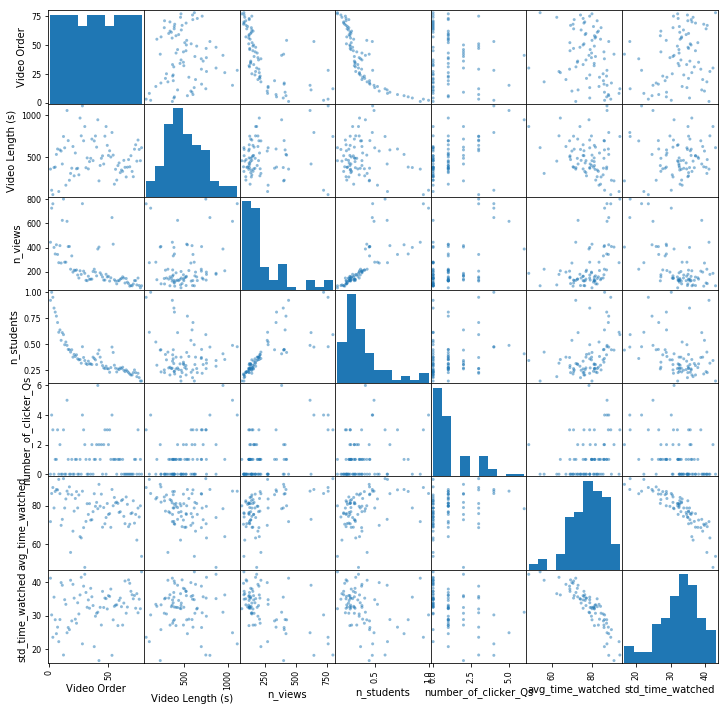

In [46]:
pdplot.scatter_matrix(df, alpha=0.5, figsize=(12, 12))
''

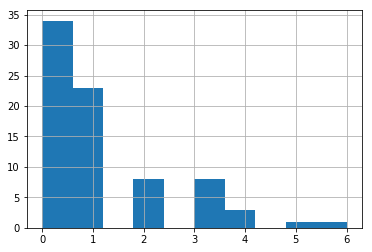

In [47]:
df['number_of_clicker_Qs'].hist()

## Dealing with number of clicker questions

Sine it seems like the number of clicker questions isn't going to be a good feature to have multiple values, I've changed it to either be true or false

In [48]:
df['has_clicker_questions'] = df.apply(lambda row: 1 if row['number_of_clicker_Qs']>0 else 0, axis=1)

In [49]:
df.columns

Index(['Video Order', 'Title', 'Video Length (s)', 'video_type', 'n_views',
       'n_students', 'number_of_clicker_Qs', 'avg_time_watched',
       'std_time_watched', 'has_clicker_questions'],
      dtype='object')

In [50]:
LR = LogisticRegression()


In [51]:
train_ids = np.random.choice(df['Video Order'], 39)
train = df[df['Video Order'].isin(train_ids)]
test = df[~df['Video Order'].isin(train_ids)]

In [52]:
features = ['Video Order','Video Length (s)', 'n_views',
       'n_students', 'avg_time_watched',
       'std_time_watched', 'has_clicker_questions']

train_x = train[features]
train_y = train['video_type']

In [53]:
test_x = test[features]
test_y = test['video_type']

In [54]:
lrfit = LR.fit(train_x, train_y)

In [55]:
lrfit.score(test_x, test_y)

0.76744186046511631

In [56]:
predictions = LR.predict(test_x)

In [57]:
 metrics.confusion_matrix(test_y, predictions)

array([[ 6,  1],
       [ 9, 27]])

# TODO

## read the evaluating the model chapter again and go through those steps

# TODO

## read the evaluating the model chapter again and go through those steps

## Here we set equal number lab and lecture videos for the model

This makes it so it isn't just classifying everything as lecture since there are 14 lab videos and 64 lecture videos.

In [58]:
not_r_squareds = []
coefs = []
run = []
for n in np.arange(1000):

    lecture_id_train = np.random.choice(df[df['video_type']=='lecture video']['Video Order'], 5)
    lab_id_train = np.random.choice(df[df['video_type']=='lab video']['Video Order'], 5)
    train_ids = np.concatenate([lecture_id_train, lab_id_train])

    train = df[df['Video Order'].isin(train_ids)]
    test = df[~df['Video Order'].isin(train_ids)]

    features = ['Video Order','Video Length (s)', 'n_views',
           'n_students', 'avg_time_watched',
           'std_time_watched', 'has_clicker_questions']

    train_x = train[features]
    train_y = train['video_type']

    test_x = test[features]
    test_y = test['video_type']

    LR2 = LogisticRegression(solver='liblinear')
    lrfit = LR.fit(train_x, train_y)
    predictions = LR.predict(test_x)

    not_r_squareds.append(lrfit.score(test_x, test_y))

    coefs.append(lrfit.coef_[0])
    
    run.append(n)

In [59]:
coefs = np.array(coefs)

(-0.5, 6.5)

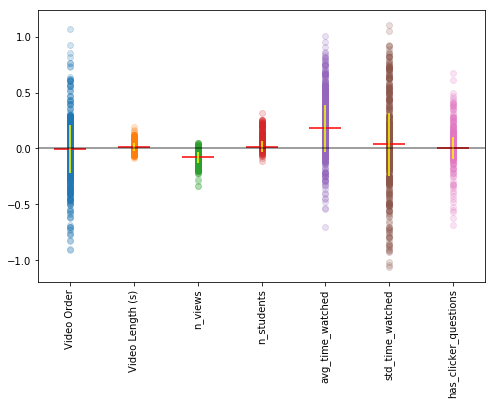

In [60]:
fig, ax = plt.subplots(figsize=(8, 5))

for n in range(7):
    ax.scatter((n,)*1000, coefs[:,n], alpha=0.2)
    ax.scatter(n, np.mean(coefs[:,n]), s=1000, marker='_', color='red')
    ax.errorbar(x=n, y=np.mean(coefs[:,n]), yerr=np.std(coefs[:,n]), color='yellow')

ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels(features, rotation=90)

ax.plot([-1, 8], [0, 0], color='black', alpha=0.5)
ax.set_xlim(-0.5, 6.5)

Text(0,0.5,'R-Score')

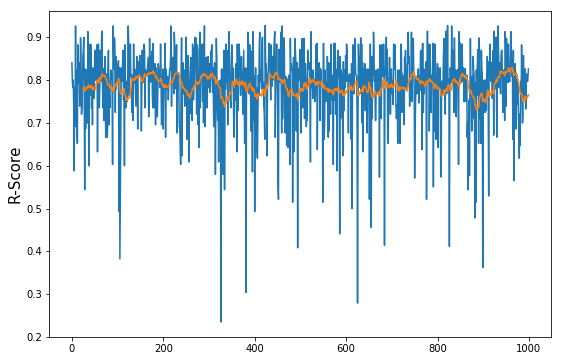

In [61]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(np.arange(1000), not_r_squareds)
ax.plot(pd.DataFrame(not_r_squareds).rolling(window=25).mean())
ax.set_ylabel('R-Score', fontsize=15)

In [62]:
metrics.confusion_matrix(test_y, predictions)

array([[ 9,  1],
       [11, 48]])

# standard scale everything

In [63]:
scaled_df = pd.DataFrame(preprocessing.scale(df[features]), columns=features)

''

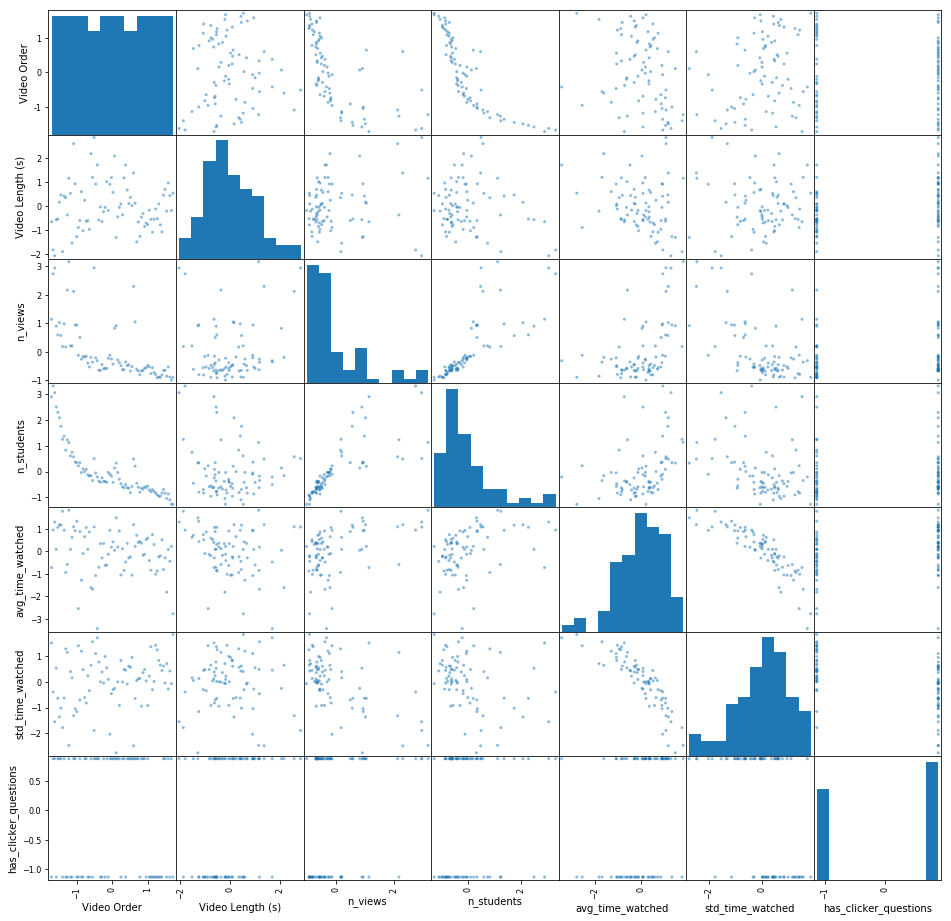

In [64]:
pdplot.scatter_matrix(scaled_df, figsize=(16, 16))
''

In [65]:
df.columns

Index(['Video Order', 'Title', 'Video Length (s)', 'video_type', 'n_views',
       'n_students', 'number_of_clicker_Qs', 'avg_time_watched',
       'std_time_watched', 'has_clicker_questions'],
      dtype='object')

In [66]:
scaled_df = df.join(scaled_df, lsuffix='_df')[df.columns]

In [67]:
not_r_squareds = []
coefs = []
run = []
fprs = []
tprs = []
for n in np.arange(1000):

    lecture_id_train = np.random.choice(scaled_df[scaled_df['video_type']=='lecture video']['Video Order'], 5)
    lab_id_train = np.random.choice(scaled_df[scaled_df['video_type']=='lab video']['Video Order'], 5)
    train_ids = np.concatenate([lecture_id_train, lab_id_train])

    train = scaled_df[scaled_df['Video Order'].isin(train_ids)]
    test = scaled_df[~scaled_df['Video Order'].isin(train_ids)]

    features = ['Video Order','Video Length (s)', 'n_views',
           'n_students', 'avg_time_watched',
           'std_time_watched', 'has_clicker_questions']

    train_x = train[features]
    train_y = train['video_type']

    test_x = test[features]
    test_y = test['video_type']

    LR2 = LogisticRegression(solver='liblinear')
    lrfit = LR.fit(train_x, train_y)
    predictions = LR.predict(test_x)
    
    predict_prob = lrfit.predict_proba(test_x)

    rocdf = pd.DataFrame({'test':test_y})
    rocdf['test_bin'] = rocdf.apply(lambda row: 1 if row['test']=='lab video' else 0, axis=1)

    fpr, tpr, thresholds = metrics.roc_curve(rocdf['test_bin'], predict_prob[:,1])

    not_r_squareds.append(lrfit.score(test_x, test_y))

    coefs.append(lrfit.coef_[0])
    
    run.append(n)
    
    fprs.append(fpr)
    tprs.append(tpr)
    
coefs = np.array(coefs)

(-0.5, 6.5)

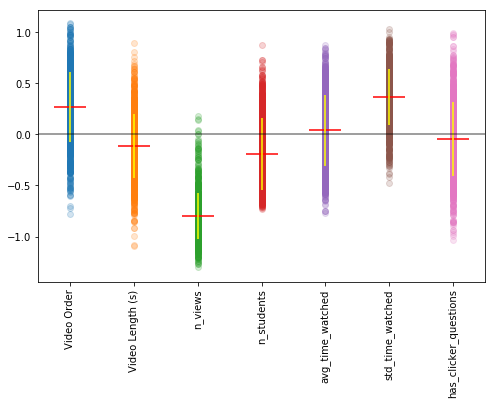

In [68]:
fig, ax = plt.subplots(figsize=(8, 5))

for n in range(7):
    ax.scatter((n,)*1000, coefs[:,n], alpha=0.2)
    ax.scatter(n, np.mean(coefs[:,n]), s=1000, marker='_', color='red')
    ax.errorbar(x=n, y=np.mean(coefs[:,n]), yerr=np.std(coefs[:,n]), color='yellow')

ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels(features, rotation=90)

ax.plot([-1, 8], [0, 0], color='black', alpha=0.5)
ax.set_xlim(-0.5, 6.5)

Text(0,0.5,'R-Score')

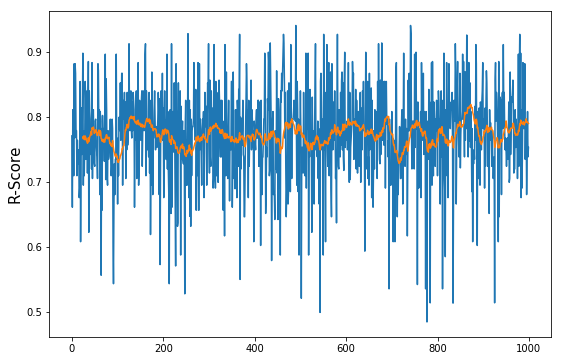

In [69]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(np.arange(1000), not_r_squareds)
ax.plot(pd.DataFrame(not_r_squareds).rolling(window=25).mean())
ax.set_ylabel('R-Score', fontsize=15)

In [70]:
# predict_prob = lrfit.predict_proba(test_x)

# rocdf = pd.DataFrame({'test':test_y})
# rocdf['test_bin'] = rocdf.apply(lambda row: 1 if row['test']=='lab video' else 0, axis=1)

# fpr, tpr, thresholds = metrics.roc_curve(rocdf['test_bin'], predict_prob[:,1])

Text(0.5,0,'False Positive Rate')

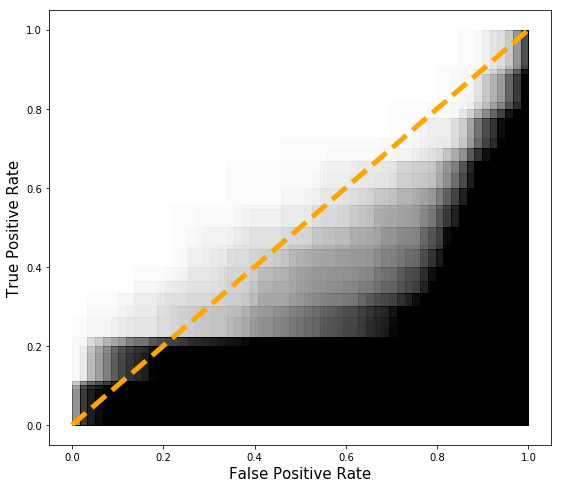

In [71]:
fig, ax = plt.subplots(figsize=(9, 8))

for f,t in zip(fprs, tprs):
    ax.fill_between(f, 0, t, color='black', alpha=0.01)
    
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=5)
ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)

(0, 1)

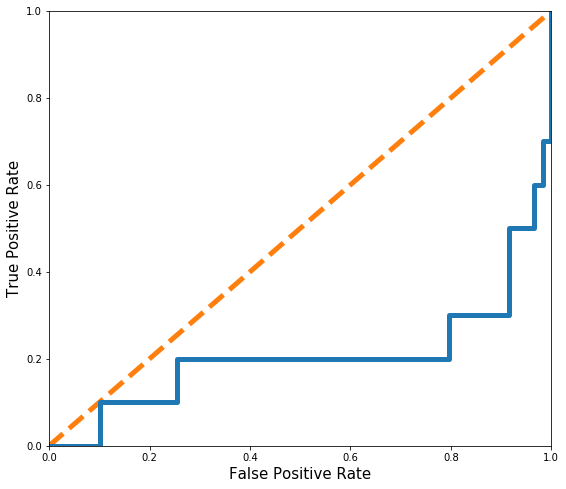

In [28]:
fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, linewidth=5)
ax.plot([0, 1], [0, 1], linestyle='--', linewidth=5, zorder=0)

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)

ax.set_ylim(0, 1)
ax.set_xlim(0, 1)